In [8]:
from datasets import load_dataset, load_from_disk
import wordninja
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import re
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import datasets
import transformers
from transformers import AutoTokenizer, default_data_collator, get_scheduler
from hf_transformers.src.transformers.models.bert.configuration_bert import BertConfig
from hf_transformers.src.transformers.models.bert.modeling_bert import BertForPreTraining

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

import sys
import math

import collections


from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score

In [70]:
#WARNING
#cacheディレクトリの指定は絶対マウント先のフォルダにするように
#そうしないとdockerイメージを管理している研究室サーバーの/がパンパンになってしまう
#/が容量オーバーすると何も動かなくなって他の人に迷惑
!export HF_DATASETS_CACHE="/home/"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
#Codes for PCA ref: https://www.kaggle.com/code/javigallego/massive-pca-outlier-detection-tutorial#3-|-PCA-for-Data-Science

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [6]:
df_hdfs_anomaly = pd.read_csv("./logdata/hdfs/anomaly_label.csv")

In [9]:
def log2list(path):
    with open(path, "r") as f:
        lines = [line.rstrip("\n") for line in f]
    return lines

hdfs = log2list("./logdata/hdfs/HDFS.log")
log_label_pairs = {}

df_hdfs_logs = pd.DataFrame({"log" : hdfs})
df_hdfs_logs["BlockId"] = df_hdfs_logs["log"].map(lambda line : re.search(r"blk_[-]*[0-9]+", line).group(0))
df_hdfs = df_hdfs_anomaly.merge(df_hdfs_logs, how="left", on=["BlockId"])

df_hdfs_without_duplicate = df_hdfs.drop_duplicates(["BlockId"])
df_hdfs_without_duplicate.to_csv("./logdata/hdfs/df_hdfs_without_duplicate.csv")

In [10]:
df_hdfs_without_duplicate

,BlockId,Label,log
0,blk_-1608999687919862906,Normal,081109 203518 143 INFO dfs.DataNode$DataXceive...
269,blk_7503483334202473044,Normal,081109 203520 142 INFO dfs.DataNode$DataXceive...
291,blk_-3544583377289625738,Anomaly,081109 203521 145 INFO dfs.DataNode$DataXceive...
514,blk_-9073992586687739851,Normal,081109 203523 143 INFO dfs.DataNode$DataXceive...
536,blk_7854771516489510256,Normal,081109 203529 148 INFO dfs.DataNode$DataXceive...
...,...,...,...
11175536,blk_1019720114020043203,Normal,081111 110351 27174 INFO dfs.DataNode$DataXcei...
11175555,blk_-2683116845478050414,Normal,081111 110359 26685 INFO dfs.DataNode$DataXcei...
11175574,blk_5595059397348477632,Normal,081111 110402 27311 INFO dfs.DataNode$DataXcei...
11175593,blk_1513937873877967730,Normal,081111 110412 27231 INFO dfs.DataNode$DataXcei...


In [64]:
# df_hdfs_without_duplicate["text"] = df_hdfs_without_duplicate["log"].map(preprocess_log)

In [11]:
import transformers
transformers.__version__

'4.31.0.dev0'

In [12]:
#分類と事前学習で異なるトークナイザを利用している？
#根拠: 例えばHDFSの異常検知の場合, 異常ラベルはログデータのブロック番号と紐づけられている

In [13]:
#NOTE
#ここで記号を区切ってwordninjaで塊除去を行っている
#なお, かなり時間がかかるので実行には注意が必要
#もう少し賢く書きたかったが, その書き方を思いつく時間とナイーブに実行する時間はどうせ同じぐらいだろう
def preprocess_log(text, remove_digits=True):
    text = text.replace('[', " ")
    text = text.replace(".", " ")
    text = text.replace(",", " ")
    text = text.replace(":", " ")
    text = text.replace("/", " ")
    text = text.replace(";", " ")
    text = text.replace("=", " ")
    text = text.replace("*", " ")
    text = text.replace("_", " ")
    text = text.replace("-", " ")
    text = text.lower()
    text = " ".join(wordninja.split(text))
    remove_num = lambda eg : " ".join([word for word in eg.split(" ") if not word.isdigit()])
    if remove_digits:
        return remove_num(text)
    return text;

def preprocess_log_batch(example, remove_digits=True):
    return {
        "text": [preprocess_log(l, remove_digits=remove_digits) for l in example["log"]]
    }

In [8]:
df_ad_hdfs = pd.read_csv("./logdata/hdfs/hdfs_log_label_pairs.csv", usecols=["log", "BlockId", "Label"])
# df_hdfs_without_duplicate["text"] = df_hdfs_without_duplicate["log"].map(preprocess_log)

In [10]:
datased_ad_hdfs = load_dataset("csv", data_files="./logdata/hdfs/hdfs_log_label_pairs.csv")
datased_ad_hdfs = datased_ad_hdfs["train"].train_test_split(0.2)
datased_ad_hdfs = datased_ad_hdfs.remove_columns(['Unnamed: 0'])
datased_ad_hdfs

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1098.27it/s]


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-81d414b48ce383ec/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


DatasetDict({
    train: Dataset({
        features: ['log', 'BlockId', 'Label'],
        num_rows: 8940503
    })
    test: Dataset({
        features: ['log', 'BlockId', 'Label'],
        num_rows: 2235126
    })
})

In [14]:
dataset_hdfs = load_dataset("csv", data_files="./logdata/hdfs/df_hdfs_without_duplicate.csv")
dataset_hdfs = dataset_hdfs["train"].train_test_split(0.2)
dataset_hdfs = dataset_hdfs.remove_columns(['Unnamed: 0'])

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 114.83it/s]


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8d2c1362a4f07327/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


In [15]:
dataset_hdfs

DatasetDict({
    train: Dataset({
        features: ['BlockId', 'Label', 'log'],
        num_rows: 460048
    })
    test: Dataset({
        features: ['BlockId', 'Label', 'log'],
        num_rows: 115013
    })
})

In [16]:
train_data = dataset_hdfs["train"]
test_valid = dataset_hdfs["test"].train_test_split(0.5)
test_dataset = test_valid["test"]
eval_dataset = test_valid["train"]
test_valid

DatasetDict({
    train: Dataset({
        features: ['BlockId', 'Label', 'log'],
        num_rows: 57506
    })
    test: Dataset({
        features: ['BlockId', 'Label', 'log'],
        num_rows: 57507
    })
})

In [17]:
train_data = train_data.map(
    preprocess_log_batch,
    batched=True,
)

In [18]:
eval_dataset = eval_dataset.map(
    preprocess_log_batch,
    batched=True,
)

test_dataset = test_dataset.map(
    preprocess_log_batch,
    batched=True,
)

In [36]:
train_data

Dataset({
    features: ['log', 'BlockId', 'Label'],
    num_rows: 8940503
})

In [19]:
log_tokenizer = AutoTokenizer.from_pretrained("./tokenizers/log_tokenizer_from_old_large/")
log_tokenizer_w_n = AutoTokenizer.from_pretrained("./tokenizers/log_tokenizer_from_old_without_numbers/")

batch_size=16  # change to 16 for full training

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    batch["labels"] = list(map(lambda x : int(x == "Normal"), batch["Label"]))

    return log_tokenizer_w_n(batch["text"], padding="max_length", truncation=True, max_length=180)



In [20]:
tokenized_train_data = train_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=1000, 
    remove_columns=['log', 'BlockId', 'Label', 'text']
)
tokenized_train_data

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 460048
})

In [36]:
X = np.array(tokenized_train_data["input_ids"], dtype=float)

In [63]:
X = pd.DataFrame(X, columns=[f"f{i + 1}" for i in range(X.shape[1])])

In [65]:
pca, X_pca, loadings = apply_pca(X, standardize=False)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

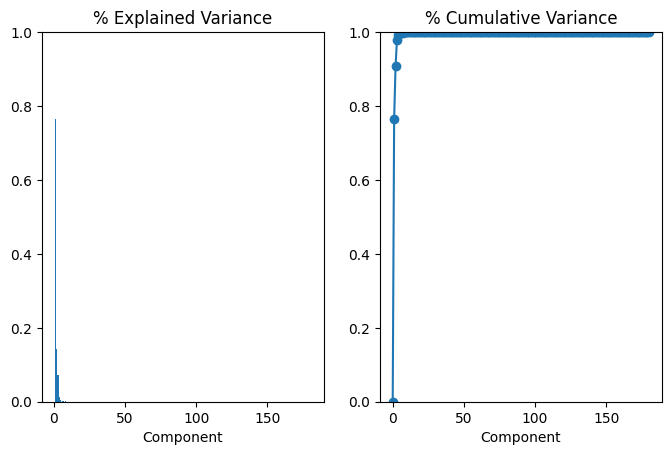

In [69]:
plot_variance(pca)

In [86]:
tokenized_train_data.set_format(type="torch")

In [88]:
small_train_dataset = tokenized_train_data.shuffle(seed=42).select(range(1000))


In [ ]:
eval_dataset = eval_dataset.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=['log', 'BlockId', 'Label', 'text']
)


eval_dataset.set_format(type="torch")
small_eval_dataset = eval_dataset.shuffle(seed=42).select(range(1000))

In [157]:
test_dataset = test_dataset.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=['log', 'BlockId', 'Label', 'text']
)


test_dataset.set_format(type="torch")
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [148]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_train_data, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

In [171]:
from hf_transformers.src.transformers.models.bert.modeling_bert import BertForSequenceClassification
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unilogConfigmodel = BertForSequenceClassification.from_pretrained("./logdata/unilog_pretrain_preln_on_attentions_0/", num_labels=2).to(device)
optimizer = AdamW(unilogConfigmodel.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./logdata/unilog_pretrain_preln_on_attentions_0/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [172]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [151]:
import evaluate

In [169]:
del tqdm

In [170]:
from tqdm.auto import tqdm

In [173]:
train_steps = 0

save_steps = 10000

best_f1 = 0.0

for epoch in range(num_epochs):
    unilogConfigmodel.train()
    for batch in tqdm(train_dataloader):
        train_steps += 1
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = unilogConfigmodel(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        if train_steps % save_steps == 0:
            unilogConfigmodel.save_pretrained(f"./logdata/log_anomaly_model_step_{train_steps}")
    import evaluate

    metric_acc = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")
    metric_precision = evaluate.load("precision")
    metric_recall = evaluate.load("recall")

    unilogConfigmodel.eval()
    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = unilogConfigmodel(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric_acc.add_batch(predictions=predictions, references=batch["labels"])
        metric_f1.add_batch(predictions=predictions, references=batch["labels"])
        metric_precision.add_batch(predictions=predictions, references=batch["labels"])
        metric_recall.add_batch(predictions=predictions, references=batch["labels"])

    print(metric_acc.compute())
    print(metric_precision.compute())
    print(metric_recall.compute())
    
    curr_f1_score = metric_f1.compute()["f1"]
    prev_f1_score = best_f1
    if (curr_f1_score > prev_f1_score):
        best_f1 = max(best_f1, curr_f1_score)
        unilogConfigmodel.save_pretrained(f"./logdata/log_anomaly_model_best")


100%|██████████| 7189/7189 [00:47<00:00, 151.82it/s]


{'accuracy': 0.9707508781692346}
{'precision': 0.9707508781692346}
{'recall': 1.0}


100%|██████████| 7189/7189 [00:48<00:00, 147.09it/s]


{'accuracy': 0.9707508781692346}
{'precision': 0.9707508781692346}
{'recall': 1.0}


 67%|██████▋   | 38767/57506 [12:37<05:33, 56.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [178]:
import evaluate

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

unilogBestModel = BertForSequenceClassification.from_pretrained("./logdata/log_anomaly_model_best/", num_labels=2).to(device)
unilogBestModel.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = unilogBestModel(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric_acc.add_batch(predictions=predictions, references=batch["labels"])
    metric_f1.add_batch(predictions=predictions, references=batch["labels"])
    metric_precision.add_batch(predictions=predictions, references=batch["labels"])
    metric_recall.add_batch(predictions=predictions, references=batch["labels"])
    
print(metric_acc.compute())
print(metric_f1.compute())
print(metric_precision.compute())
print(metric_recall.compute())

{'accuracy': 0.9705427165388562}
{'f1': 0.9850511824920578}
{'precision': 0.9705427165388562}
{'recall': 1.0}
